# ICU Mortality Prediction

## Contents
- [Introduction](#introduction)
    - [MIMIC III Database](#mimiciii-database)
    - [Problem Statement](#problem-statement)
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#feature_engineering)
- [Model Development](#model_development)
    - [Logistic Regression](#logistic_regression)
    - [Random Forest](#random_forest)
    - [Support Vector Machine (SVM)](#svm)
- [Best Model Analysis](#model_analysis)
- [Conclusions](#conclusions)
- [Acknowledgements](#acknowledgements)

In [8]:
%%html
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-Cell-inputArea').hide();
     $('div.input').hide();
 } else {
 $('div.jp-Cell-inputArea').show();
     $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

## Introduction <a class="anchor" id="introduction"></a>

<b>MIMIC III Database</b><a class="anchor" id="mimiciii-database"></a><br>
The Medical Information Mart for Intensive Care III (MIMIC III) database contains deidentified records of **46,520** patients admitted to critical care units at *Beth Israel Deaconess Medical Center* between *2001* and *2012*. In total, **61,532** intensive care unit stays were recorded. **53,432** stays were adult patients and **8,100** stays were neonatal patients. 



<b>Problem Statement</b><a class="anchor" id="problem-statement"></a><br>
Study factors which influence an intensive care patient's survival and build a classifier machine learning model to predict patient mortality.

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

MIMIC III has a myriad of fields that could provide keen insights. Below are the columns studied to get a better understanding of the data:<br>
<ul>Age, Height, Weight, Gender, Heart Rate, Temperature, SpO2, Blood Pressure, Race, Marital Status, ICD9 codes, Prescriptions, Number of Admissions</ul>

In [1]:
import os
import psycopg2
import pandas as pd

# notebook options
import warnings
warnings.filterwarnings('ignore')

In [2]:
# connecting to postgres database
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRESPWD = os.environ['POSTGRESPWD']

conn = psycopg2.connect("dbname=mimic user={} password={}".format(POSTGRESUSER,POSTGRESPWD))
cur = conn.cursor()

In [3]:
# getting patients table
querystr = 'select * from mimiciii.patients'
patients = pd.read_sql_query(querystr, conn)

In [4]:
# getting admissions table
querystr = 'select * from mimiciii.admissions'
admissions = pd.read_sql_query(querystr, conn)

In [5]:
# calculating number of times a patient is admitted
staycount = admissions.groupby('subject_id').agg(staycount=('row_id','count'))
patients = patients.join(staycount, how='left', on='subject_id')

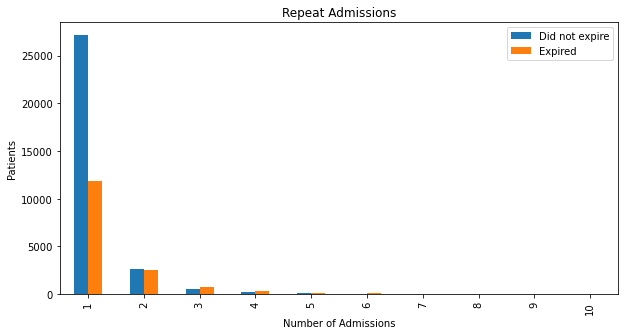

In [42]:
# stay count vs expiration
stay_exp = patients.groupby(['staycount','expire_flag']).agg(number_of_patients=('row_id','count'))
# grouping to admitted and readmitted
stay_exp_grpd = stay_exp.reset_index()
stay_exp_grpd['readmitted'] = stay_exp_grpd['staycount']>1
stay_exp_grpd['readmitted'] = stay_exp_grpd['readmitted'].apply(lambda x: 'More than one admission' if x else 'Admitted once')
stay_exp_grpd = stay_exp_grpd.drop(columns=['staycount']).groupby(['readmitted','expire_flag']).sum()

# plotting number of readmits below 10
stay_exp = stay_exp[stay_exp.index.get_level_values('staycount')<=10]

fig=stay_exp.reset_index().pivot(index='staycount', columns='expire_flag', values='number_of_patients')\
    .plot.bar(figsize=(10,5), title='Repeat Admissions', 
              xlabel='Number of Admissions',ylabel='Patients')
fig.legend(['Did not expire', 'Expired']);

Patients with repeat ICU admissions exhibited a significantly decreased chance of survival. Since there are fewer instances, effects of readmission may not be accurately represented.

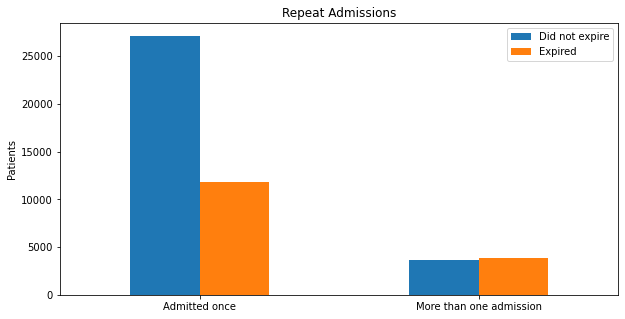

In [43]:
# plotting no readmission vs readmission
fig=stay_exp_grpd.reset_index().pivot(index='readmitted', columns='expire_flag', values='number_of_patients')\
    .plot.bar(figsize=(10,5), title='Repeat Admissions', 
              xlabel='',ylabel='Patients', rot=0)
fig.legend(['Did not expire', 'Expired']);

Pooling all readmissions into one group, the effects of readmission can be interpreted with better confidence. A third of patients admitted once expired whereas more than half of readmitted patients expired.

## Feature Engineering<a class="anchor" id="feature_engineering"></a>

## Model Development<a class="anchor" id="model_development"></a>

### Logistic Regression <a class="anchor" id="logistic_regression"></a>

### Random Forest <a class="anchor" id="random_forest"></a>

### Support Vector Machine (SVM) <a class="anchor" id="svm"></a>

## Best Model Analysis<a class="anchor" id="model_analysis"></a>

## Conclusions<a class="anchor" id="conclusions"></a>

In [136]:
cur.close()
conn.close()

## Acknowledgements <a class="anchor" id="acknowledgements"></a>
The MIMIC III database was made available through the efforts of MIT Laboratory for Computational Physiology and collaborating research groups and supported by National Institute of Biomedical Imaging and Bioengineering (NIBIB) of the National Institutes of Health (NIH). <br><br>
Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).


In [44]:
# cli code to convert notebook to html
!jupyter nbconvert --to html icu_mortality_prediction.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"hide_input"}'


C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2199: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'remove_cell' instead of "'remove_cell'" – or use CUnicode.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2199: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'hide_input' instead of "'hide_input'" – or use CUnicode.
  FutureWarning)
[NbConvertApp] Converting notebook icu_mortality_prediction.ipynb to html
[NbConvertApp] Writing 617772 bytes to icu_mortality_prediction.html
